In [2]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from lib.metrics import RMSE
from lib.read_data import read_data, test_column, test_date_column
from lib.train import TrainInfo, train_data_series
from lib.filter_data import filter_data
from lib.shap_utils import \
    explain_model, \
    shap_dependence_plot, \
    shap_get_feature_importance_df, \
    get_most_important_cols
from lib.data_series import DataSerie
from lib.plot_train_results import \
    plot_results_sorted_by_target_and_prediction, \
    plot_results_sorted_by_amh_and_target, \
    plot_amh_histogram

shap.initjs()

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

%load_ext autoreload
%autoreload 2

# READ DATA

In [3]:
data = read_data('/dysk1/approx/invicta/1.1.1./', merge_with_meds=True, merge_with_patient_genes=True)

pickups_df:                  981
merged with meds_df:         936
merged with patient_gens_df: 922
merged with poli_changes_df: 922
merged with causes_df: 922
merged with patient_groups_df: 922
-
dhea_s:          low: 2%,  normal: 87%, high: 11%, filled: 63%, ()
shbg:            low: 1%,  normal: 80%, high: 19%, filled: 39%, ()
testosterone:    low: 49%, normal: 46%, high: 5%, filled: 40%, ()
fsh:             low: 9%,  normal: 64%, high: 26%, filled: 45%, (?)
tsh:             low: 65%, normal: 32%, high: 3%, filled: 72%, ()
lh:              low: 5%,  normal: 74%, high: 22%, filled: 28%, (faza folikularna)
e2:              low: 86%, normal: 10%, high: 3%, filled: 35%, (faza folikularna)
inhibina_b:      low: 34%, normal: 46%, high: 21%, filled: 48%, (faza folikularna)
-
valid_dhea_s:    low: 1%,  normal: 87%, high: 12%, filled: 48%, ()
valid_shbg:      low: 1%,  normal: 79%, high: 20%, filled: 23%, ()
valid_testosterone: low: 53%, normal: 42%, high: 5%, filled: 24%, ()
valid_fsh:       

# PREPARE DATA SERIES

In [5]:
DATA_SERIES = {}

In [6]:
input_df = data.input_df
target_col = 'cumulus_denuded'

print(f'Original records: {len(input_df)}')
input_df = filter_data(input_df, ~input_df['pickups_process_type'].isin([
    'DAWKJ', 'BIOKJ', 'DD', 'DS']))
input_df = filter_data(input_df, ~input_df['lek_Gonadotropiny'].str.contains('Elonva'))
input_df = filter_data(input_df, ~input_df[target_col].isnull())
input_df = filter_data(input_df, ~input_df['test_amh_r'].isnull())
input_df = filter_data(input_df, input_df['test_amh_r'] < 15.0)
print(f'Filtered records: {len(input_df)}')

DATA_SERIES[target_col] = DataSerie(
    input_df = input_df,
    target_col = target_col,
)

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  14
Removed records:  92
Removed records:  18
Filtered records: 530


In [7]:
input_df = data.input_df
target_col = 'day_0_mii'

print(f'Original records: {len(input_df)}')
input_df = filter_data(input_df, ~input_df['pickups_process_type'].isin([
    'DAWKJ', 'BIOKJ', 'DD', 'DS']))
input_df = filter_data(input_df, ~input_df['lek_Gonadotropiny'].str.contains('Elonva'))
input_df = filter_data(input_df, ~input_df[target_col].isnull())
input_df = filter_data(input_df, ~input_df['test_amh_r'].isnull())
input_df = filter_data(input_df, input_df['test_amh_r'] < 15.0)
print(f'Filtered records: {len(input_df)}')

DATA_SERIES[target_col] = DataSerie(
    input_df = input_df,
    target_col = target_col,
)

Original records: 922
Removed records:  268
Removed records:  0
Removed records:  30
Removed records:  90
Removed records:  18
Filtered records: 516


# BASE LGB_PARAMS

In [8]:
LGB_PARAMS_BASE = {
    'objective': 'regression_l2',
    'metric': ['rmse', 'l1', 'l2'],
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'verbose': -1,
    'num_leaves': 5,
    'max_depth': 16,
    'max_bin': 63,
    'seed': 42,
    'num_threads': 10,
    'num_boost_round': 100,
    'early_stopping_round': 10,
}
N_FOLDS = 5

# CONST MODELS

In [9]:
const_model_rmse = {}
for data_serie_name, data_serie in DATA_SERIES.items():
    input_target_mean = data_serie.input_df[data_serie.target_col].mean()
    print(
        f'MEAN[{data_serie_name}]: '.ljust(25, ' ') +
        f'{"%.2f"%input_target_mean}')
    const_model_rmse[data_serie_name] = RMSE(
        [input_target_mean] * len(data_serie.input_df),
        data_serie.input_df[data_serie.target_col]
    )
print('-')

for data_serie_name, data_serie in DATA_SERIES.items():
    print(
        f'RMSE[{data_serie_name}]: '.ljust(25, ' ') +
        f'{"%.2f"%const_model_rmse[data_serie_name]}')

MEAN[cumulus_denuded]:   7.64
MEAN[day_0_mii]:         5.92
-
RMSE[cumulus_denuded]:   6.19
RMSE[day_0_mii]:         4.75


<AxesSubplot:xlabel='test_amh_r'>

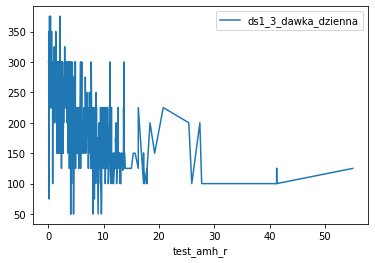

In [27]:
data.input_df[data.input_df['ds1_3_dawka_dzienna'] < 400].sort_values('test_amh_r').plot('test_amh_r', 'ds1_3_dawka_dzienna')

<AxesSubplot:>

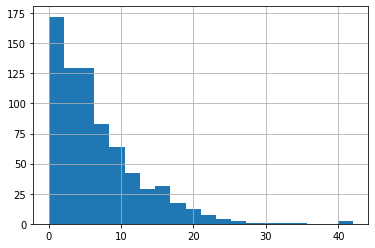

In [21]:
data.input_df['day_0_mii'].hist(bins=20)

<AxesSubplot:>

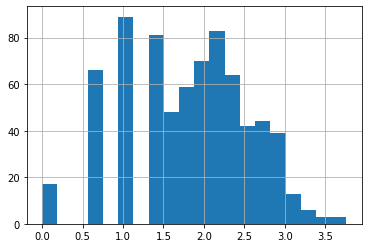

In [20]:
np.log(data.input_df['day_0_mii']+1).hist(bins=20)

# BASE EXPERIMENT

In [ ]:
BASE_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    ['test_amh_r'],
    N_FOLDS)


In [ ]:
BASE_RESULTS.train_infos['day_0_mii'].plot_learning_progress(
    plot_metrics=[
        'rmse',
        #'l1',
        #'l2',
    ],
    plot_sufixes=[
        #'upp',
        'mid',
        #'low',
    ]
)

In [ ]:
BASE_RESULTS.print_rmse(need_details=True)

In [ ]:
BASE_RESULTS.print_rmse(base_results=BASE_RESULTS)

# Plot results

In [ ]:
BASE_RESULTS

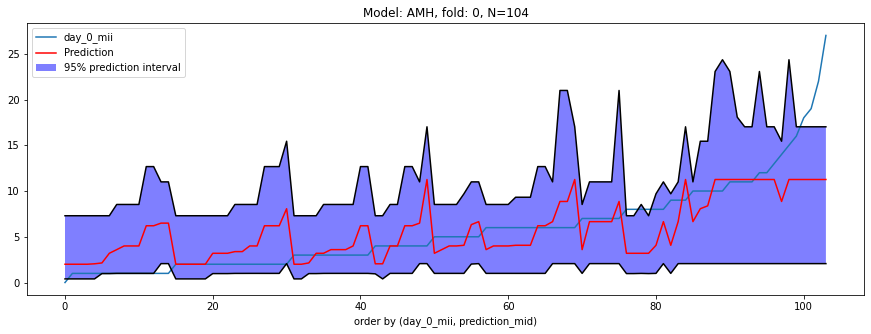

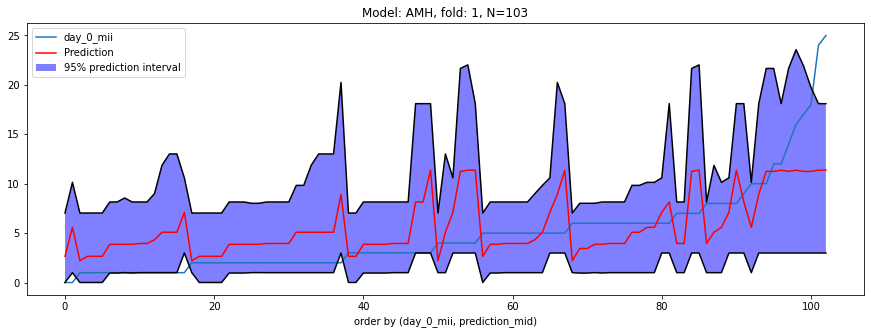

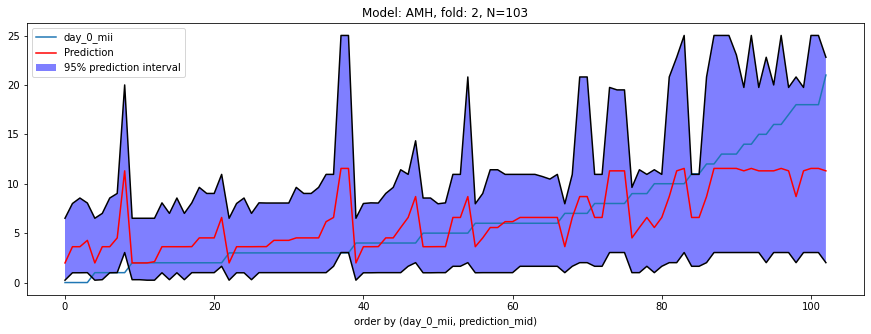

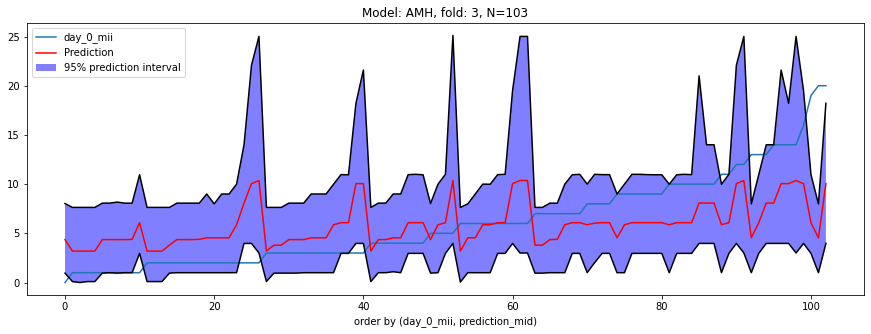

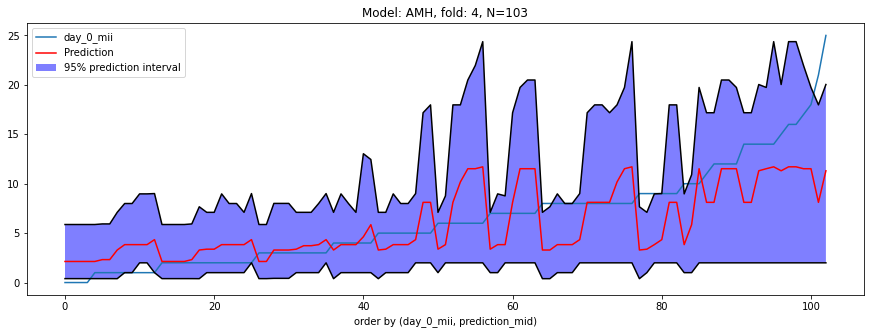

In [104]:
for fold, fold_info in enumerate(BASE_RESULTS.train_infos['day_0_mii'].fold_infos):
    plot_results_sorted_by_target_and_prediction(
        fold_info, f'Model: AMH, fold: {fold}')

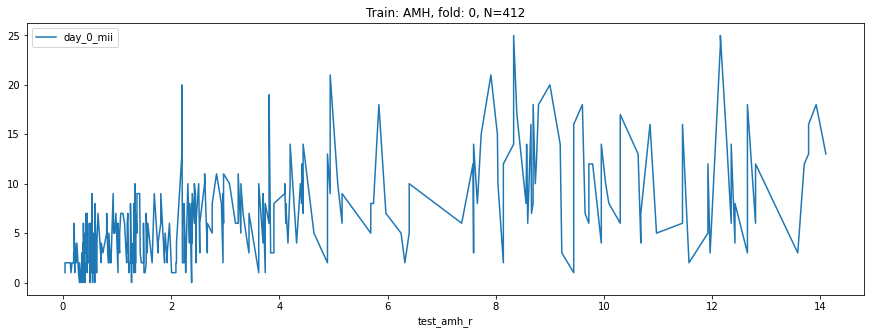

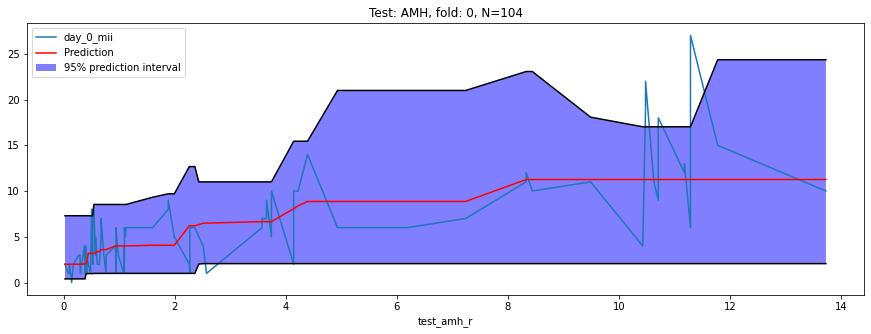

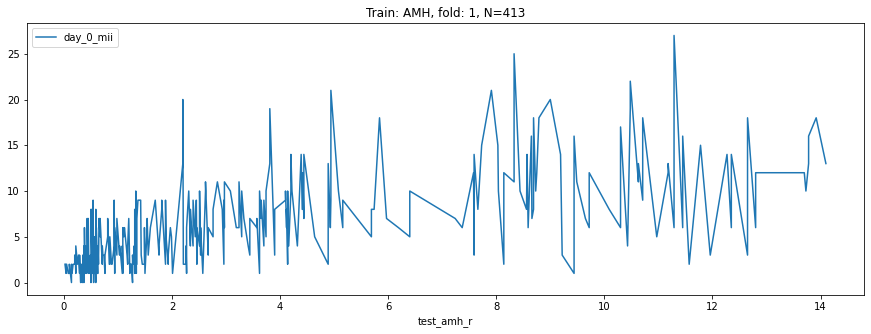

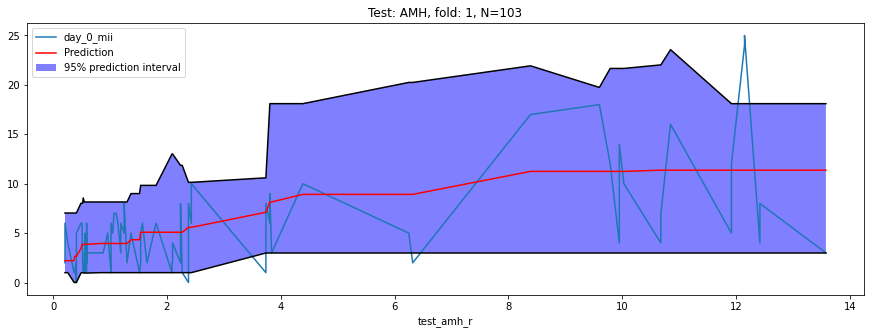

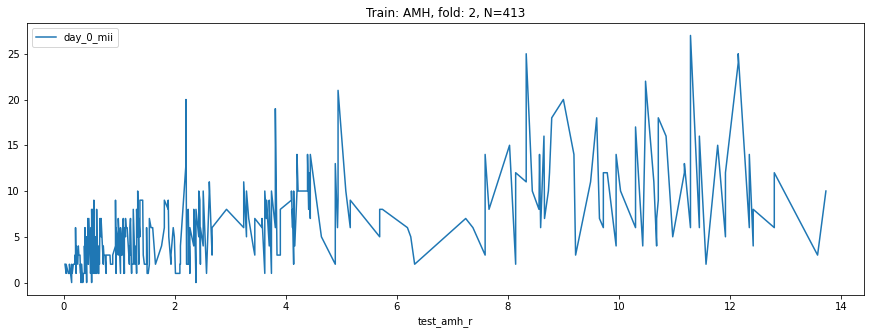

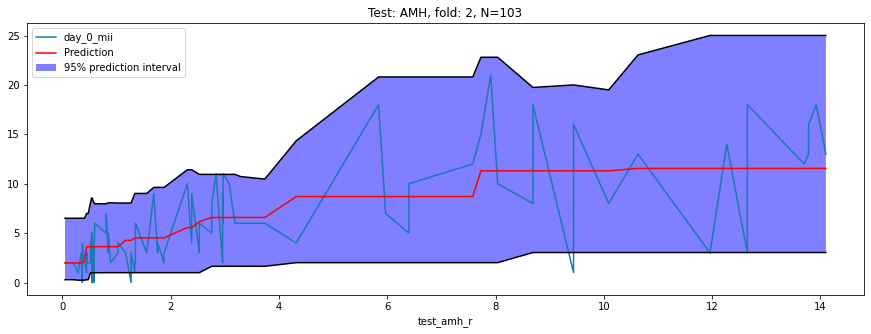

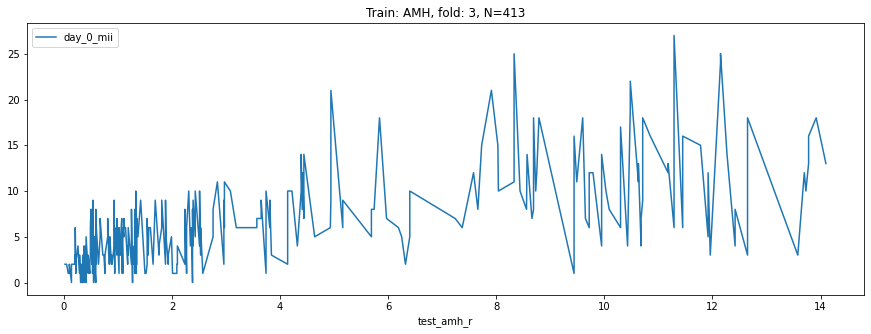

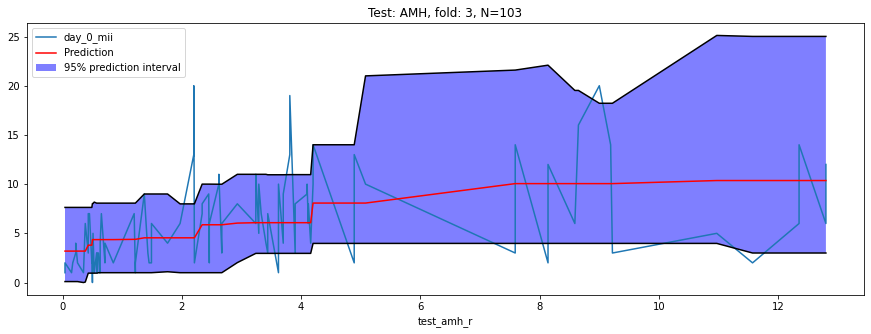

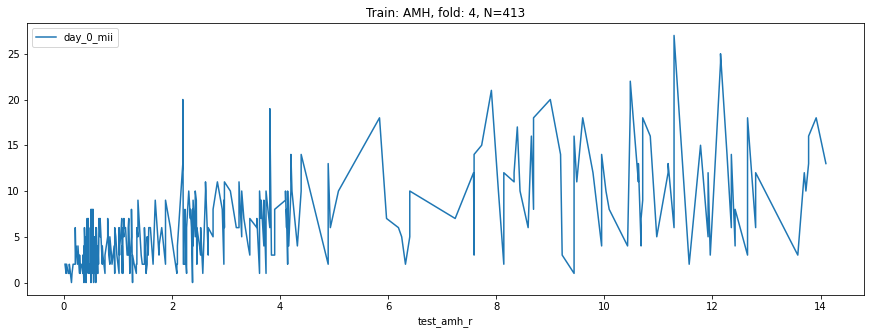

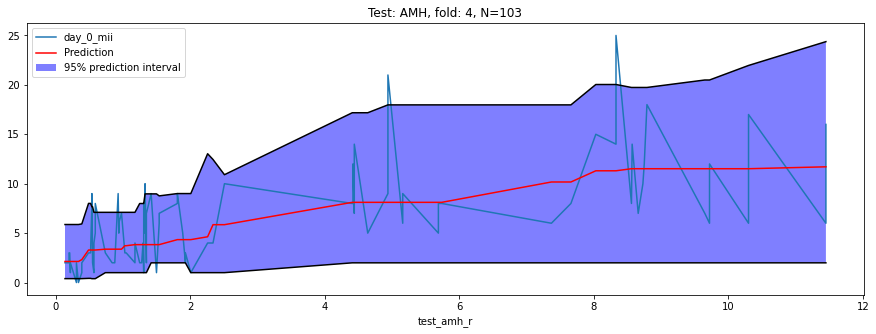

In [105]:
for fold, fold_info in enumerate(BASE_RESULTS.train_infos['day_0_mii'].fold_infos):

    plot_results_sorted_by_amh_and_target(
        fold_info, 'train', f'Train: AMH, fold: {fold}')
    
    plot_results_sorted_by_amh_and_target(
        fold_info, 'test', f'Test: AMH, fold: {fold}')

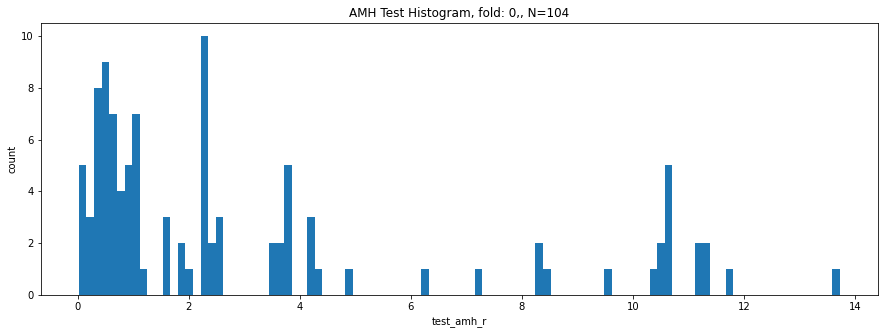

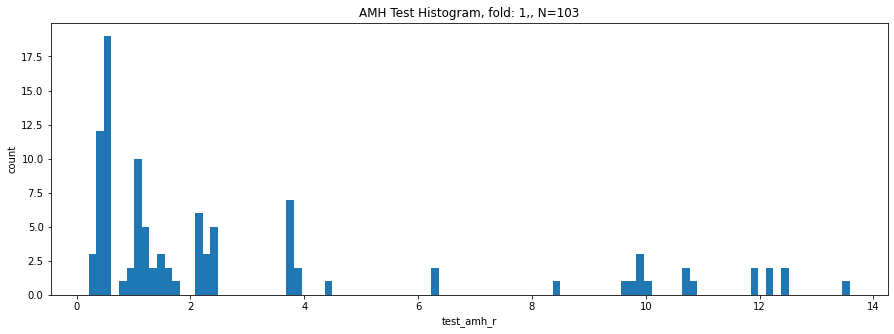

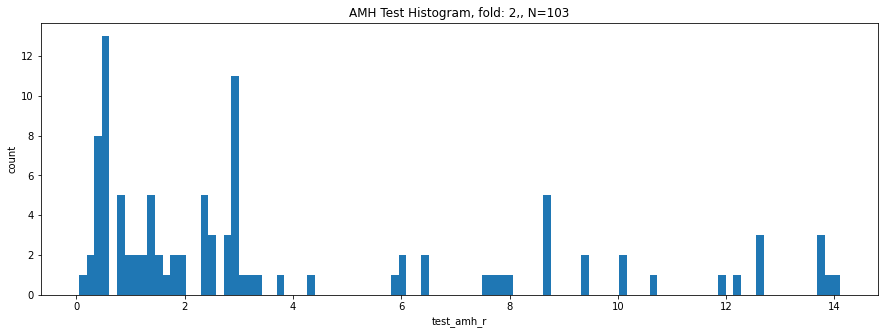

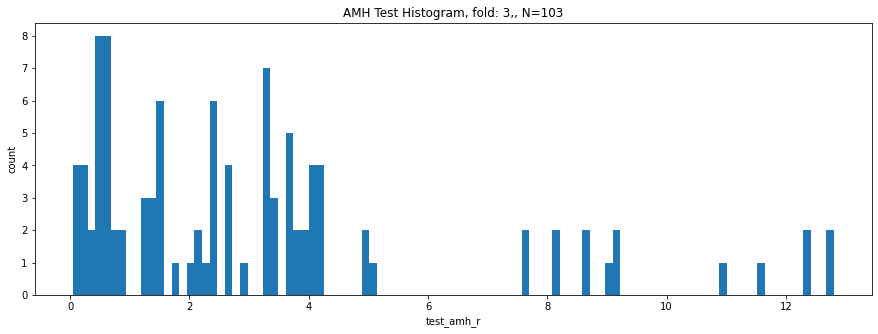

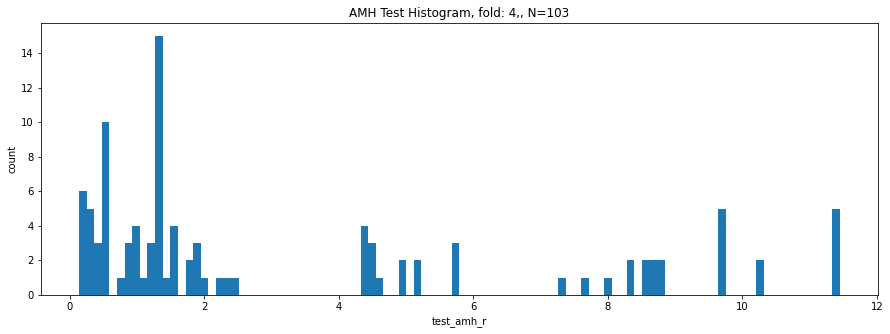

In [106]:
for fold, fold_info in enumerate(BASE_RESULTS.train_infos['day_0_mii'].fold_infos):
    plot_amh_histogram(fold_info, f'AMH Test Histogram, fold: {fold},')

# DEFINE EXPERIMENTS

In [107]:
EXPERIMENTS = {}

In [108]:
EXPERIMENTS['AMH'] = [
    'test_amh_r',
]

In [109]:
EXPERIMENTS['AMH + FSH + E2 + DS1_BUBBLE_COUNT + DS1_3_DAWKA'] = [
    'test_amh_r',
    'test_fsh_r',
    'test_e2_r',
    'ds1_bubble_count',
    'ds1_3_dawka_dzienna',
]

In [110]:
EXPERIMENTS['AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA'] = [
    'test_amh_r',
    'ds1_bubble_count',
    'ds1_3_dawka_dzienna',
    'ds4_7_dawka_dzienna',
]

In [111]:
EXPERIMENTS['AMH + FSH'] = [
    'test_amh_r',
    'test_fsh_r',
]

In [112]:
EXPERIMENTS['AMH + FSH + DS1_BUBBLE_COUNT + DS1_3_DAWKA'] = [
    'test_amh_r',
    'test_fsh_r',
    'ds1_bubble_count',
    'ds1_3_dawka_dzienna',
]

In [113]:
EXPERIMENTS['AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA'] = [
    'test_amh_r',
    'ds1_bubble_count',
    'ds1_3_dawka_dzienna',
]

In [114]:
EXPERIMENTS['AMH + PRLR_BIN'] = [
    'test_amh_r',
    'PRLR_BIN',
]

In [115]:
EXPERIMENTS['AMH + AGE'] = [
    'test_amh_r',
    'patient_age',
]

In [116]:
EXPERIMENTS['AMH + ds1_3_dawka_dzienna'] = [
    'test_amh_r',
    'ds1_3_dawka_dzienna',
]

In [117]:
EXPERIMENTS['AMH + ds1_3_dawka_dzienna + ds4_7_dawka_dzienna'] = [
    'test_amh_r',
    'ds1_3_dawka_dzienna',
    'ds4_7_dawka_dzienna',
]

In [118]:
EXPERIMENTS['AMH + ds1_3_dawka_dzienna + ds1_bubble_count_lr'] = [
    'test_amh_r',
    'ds1_3_dawka_dzienna',
    'ds1_bubble_count_l',
    'ds1_bubble_count_r',
]

In [119]:
EXPERIMENTS['AMH + AGE + ds1_3_dawka_dzienna'] = [
    'test_amh_r',
    'patient_age',
    'ds1_3_dawka_dzienna',
]

In [120]:
EXPERIMENTS['AMH + AGE + ds1_3_dawka_dzienna + ds4_7_dawka_dzienna'] = [
    'test_amh_r',
    'patient_age',
    'ds1_3_dawka_dzienna',
    'ds4_7_dawka_dzienna',
]

In [121]:
EXPERIMENTS['AMH + AGE + ds1_3_dawka_dzienna + ds1_bubble_count_lr'] = [
    'test_amh_r',
    'patient_age',
    'ds1_3_dawka_dzienna',
    'ds1_bubble_count_l',
    'ds1_bubble_count_r',
]

In [122]:
EXPERIMENTS['ds1_bubble_count_lr'] = [
    'ds1_bubble_count_l',
    'ds1_bubble_count_r',
]

In [123]:
EXPERIMENTS['AMH + all_genes_bin'] = [
    'test_amh_r',
] + data.genes_info.gene_names_binary

In [124]:
EXPERIMENTS['AMH + best_tests'] = [
    'test_amh_r',
    'test_inhibina_b_r',
    #'test_tsh_r',
    'test_e2_r',
    #'test_fsh_r',
    #'test_lh_r',
    'test_testosterone_r',
    #'test_shbg_r',
    #'test_dhea_s_r',
    #'patient_age',
    #'prot_type_cat',
]

In [125]:
EXPERIMENTS['AMH + AGE + best_tests'] = [
    'test_amh_r',
    'patient_age',
    'test_inhibina_b_r',
    #'test_tsh_r',
    'test_e2_r',
    #'test_fsh_r',
    #'test_lh_r',
    'test_testosterone_r',
    #'test_shbg_r',
    #'test_dhea_s_r',
    #'prot_type_cat',
]

In [126]:
EXPERIMENTS['AMH + MEDS'] = [
    'test_amh_r',
    'valid_avg_day_dose_HCG_stymulacja_owulacji',
    'valid_avg_day_dose_Antagonista_GnRH',
    'valid_avg_day_dose_Progesteron',
    'valid_avg_day_dose_Agonista_GnRH',
    'valid_avg_day_dose_Gonadotropiny',
]

In [127]:
EXPERIMENTS['AMH + prot_type'] = [
    'test_amh_r',
    'prot_type_cat',
]

In [128]:
EXPERIMENTS['x'] = [
    'test_amh_r',
    'test_fsh_r',
    'test_e2_r',
    'ds1_bubble_count',
    'ds1_3_dawka_dzienna',
    'ESR2_14_64227364_C_T', 'BMP15_X_50912016_G_A', 'BMP15_X_50910775_G_C', 'AR_X_67723521_ACACAC_-', 'PRLR_5_35062571_-_T', 'LHCGR_2_48698607_T_C']
    

# CONDUCT EXPERIMENTS

In [129]:
%%time

EXPERIMENT_RESULTS = {}
for experiment_name, experiment_cols in tqdm(EXPERIMENTS.items()):
    EXPERIMENT_RESULTS[experiment_name] = train_data_series(
        LGB_PARAMS_BASE, DATA_SERIES, experiment_cols, n_folds=N_FOLDS)

 90%|█████████ | 19/21 [00:18<00:01,  1.03it/s]Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
100%|██████████| 21/21 [00:20<00:00,  1.00it/s]

CPU times: user 2min 53s, sys: 1.56 s, total: 2min 55s
Wall time: 21.2 s


In [130]:
for experiment_name, experiment_results in EXPERIMENT_RESULTS.items():

    print("=========================")
    print(experiment_name)
    for train_col in experiment_results.train_cols:
        print(f' - {train_col}')
    print('-')
    
    experiment_results.print_rmse(BASE_RESULTS)


AMH
 - test_amh_r
-
# RMSE[cumulus_denuded][avg][upp]:      10.36     (0.00)
# RMSE[cumulus_denuded][avg][mid]:      4.67      (0.00)
# RMSE[cumulus_denuded][avg][low]:      8.18      (0.00)
-
# RMSE[day_0_mii][avg][upp]:            7.47      (0.00)
# RMSE[day_0_mii][avg][mid]:            3.55      (0.00)
# RMSE[day_0_mii][avg][low]:            6.17      (0.00)
-
AMH + FSH + E2 + DS1_BUBBLE_COUNT + DS1_3_DAWKA
 - test_amh_r
 - test_fsh_r
 - test_e2_r
 - ds1_bubble_count
 - ds1_3_dawka_dzienna
-
# RMSE[cumulus_denuded][avg][upp]:      8.92      (-1.44)
# RMSE[cumulus_denuded][avg][mid]:      4.51      (-0.16)
# RMSE[cumulus_denuded][avg][low]:      7.97      (-0.21)
-
# RMSE[day_0_mii][avg][upp]:            6.80      (-0.67)
# RMSE[day_0_mii][avg][mid]:            3.49      (-0.06)
# RMSE[day_0_mii][avg][low]:            6.16      (-0.01)
-
AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA
 - test_amh_r
 - ds1_bubble_count
 - ds1_3_dawka_dzienna
 - ds4_7_dawka_dzienna
-
# RMSE[cumulus_

# Explain models

In [ ]:
explain_model(
    EXPERIMENT_RESULTS['AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA'],
    data_serie_name='cumulus_denuded',
    experiment_name='AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA',
    folds=range(0, N_FOLDS),
    number_of_cases=0)

In [ ]:
explain_model(
    EXPERIMENT_RESULTS['AMH + MEDS'],
    data_serie_name='cumulus_denuded',
    experiment_name='AMH + MEDS',
    folds=range(0, N_FOLDS),
    number_of_cases=0)



In [ ]:
explain_model(
    EXPERIMENT_RESULTS['AMH + all_genes_bin'],
    data_serie_name='day_0_mii',
    experiment_name='AMH + all_genes_bin',
    folds=range(0, N_FOLDS),
    number_of_cases=0)

# SHAP DEPENDENCE PLOTS

In [ ]:
shap_dependence_plot(
    EXPERIMENT_RESULTS['AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA'],
    data_serie_name='cumulus_denuded',
    experiment_name='AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA',
    ind='ds1_3_dawka_dzienna',
    interaction_index='test_amh_r',
    folds=range(0, N_FOLDS))

In [ ]:
shap_dependence_plot(
    EXPERIMENT_RESULTS['AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA'],
    data_serie_name='cumulus_denuded',
    experiment_name='AMH + DS1_BUBBLE_COUNT + DS1_3_DAWKA + DS4_7_DAWKA',
    ind='ds4_7_dawka_dzienna',
    interaction_index='test_amh_r',
    folds=range(0, N_FOLDS))

# MEDS

In [47]:
SINGLE_MED_EXPERIMENTS = {}
for col in data.input_df.columns:
    if 'valid_avg_day_dose_' not in col:
        continue

    experiment_cols = ['test_amh_r', col]
        
    train_results = train_data_series(
        LGB_PARAMS_BASE, DATA_SERIES, experiment_cols, n_folds=N_FOLDS)
    
    print("===============")
    print(col)
    train_results.print_rmse(BASE_RESULTS)

    SINGLE_MED_EXPERIMENTS[str(experiment_cols)] = train_results
    

valid_avg_day_dose_Agonista_GnRH
# RMSE[cumulus_denuded][avg][upp]:      9.95      (-0.41)
# RMSE[cumulus_denuded][avg][mid]:      4.59      (-0.08)
# RMSE[cumulus_denuded][avg][low]:      8.10      (-0.09)
-
# RMSE[day_0_mii][avg][upp]:            7.17      (-0.29)
# RMSE[day_0_mii][avg][mid]:            3.58      (0.02)
# RMSE[day_0_mii][avg][low]:            6.13      (-0.04)
-
valid_avg_day_dose_Agonista_recep_dopaminy
# RMSE[cumulus_denuded][avg][upp]:      10.36     (0.00)
# RMSE[cumulus_denuded][avg][mid]:      4.67      (0.00)
# RMSE[cumulus_denuded][avg][low]:      8.18      (0.00)
-
# RMSE[day_0_mii][avg][upp]:            7.47      (0.00)
# RMSE[day_0_mii][avg][mid]:            3.55      (0.00)
# RMSE[day_0_mii][avg][low]:            6.17      (0.00)
-
valid_avg_day_dose_Antagonista_GnRH
# RMSE[cumulus_denuded][avg][upp]:      10.24     (-0.12)
# RMSE[cumulus_denuded][avg][mid]:      4.68      (0.01)
# RMSE[cumulus_denuded][avg][low]:      8.17      (-0.01)
-
# RMSE[day_0_mii

In [ ]:
for experiment_name in SINGLE_MED_EXPERIMENTS:
    explain_model(
        SINGLE_MED_EXPERIMENTS,
        data_serie_name='day_0_mii',
        experiment_name=experiment_name,
        folds=[0],
        number_of_cases=0)

In [ ]:
X_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    ['test_amh_r'] + ['LHCGR_2_48729278_T_C'],
    N_FOLDS)
X_RESULTS.print_rmse(base_results=BASE_RESULTS)

In [ ]:
X_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    ['test_amh_r'] + ['AR_X_67723521_ACACAC_-'],
    N_FOLDS)
X_RESULTS.print_rmse(base_results=BASE_RESULTS)

In [ ]:
X_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    ['test_amh_r', 'ESR2_14_64227364_C_T'],
    N_FOLDS)
X_RESULTS.print_rmse(base_results=BASE_RESULTS)

# ALL POLI_CHANGES

In [157]:
ALL_POLI_CHANGES_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    ['test_amh_r'] + data.poli_change_names,
    N_FOLDS)
ALL_POLI_CHANGES_RESULTS.print_rmse(base_results=BASE_RESULTS)

# RMSE[cumulus_denuded][avg][upp]:      8.85      (-1.51)
# RMSE[cumulus_denuded][avg][mid]:      4.82      (0.15)
# RMSE[cumulus_denuded][avg][low]:      8.26      (0.08)
-
# RMSE[day_0_mii][avg][upp]:            6.79      (-0.67)
# RMSE[day_0_mii][avg][mid]:            3.75      (0.20)
# RMSE[day_0_mii][avg][low]:            6.55      (0.38)
-


In [169]:
input_df['AR_X_67723521_ACACAC_-'].dtypes == np.dtype('bool')

True

In [140]:
type(input_df['AR_X_67723521_ACACAC_-'])

pandas.core.series.Series

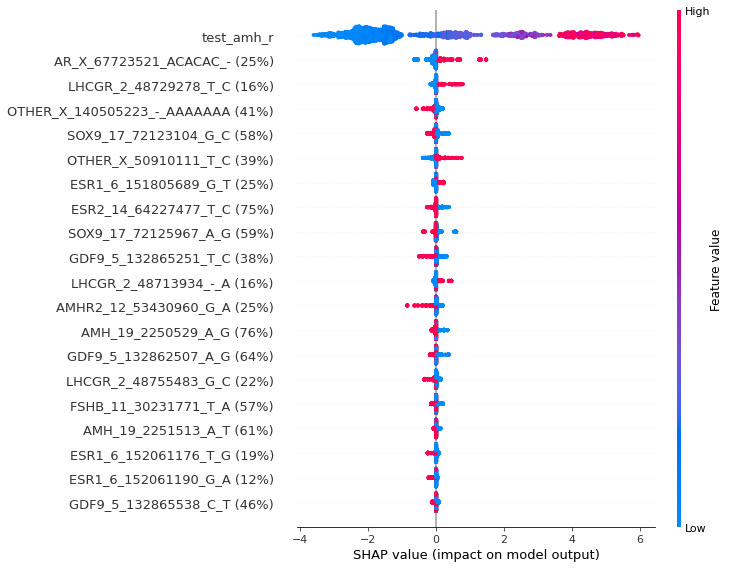

In [170]:
explain_model(
    ALL_POLI_CHANGES_RESULTS,
    data_serie_name='day_0_mii',
    folds=range(0, N_FOLDS),
    only_summary=True)

In [159]:
poli_changes_importance_df = shap_get_feature_importance_df(
    ALL_POLI_CHANGES_RESULTS, DATA_SERIES, range(0, N_FOLDS))

In [160]:
most_important_cols = get_most_important_cols(poli_changes_importance_df, DATA_SERIES, 15)

In [161]:
print(len(most_important_cols))

31


In [162]:
X_RESULTS = train_data_series(
    LGB_PARAMS_BASE,
    DATA_SERIES,
    most_important_cols,
    N_FOLDS)
X_RESULTS.print_rmse(base_results=BASE_RESULTS)

# RMSE[cumulus_denuded][avg][upp]:      8.98      (-1.38)
# RMSE[cumulus_denuded][avg][mid]:      4.67      (-0.01)
# RMSE[cumulus_denuded][avg][low]:      8.16      (-0.02)
-
# RMSE[day_0_mii][avg][upp]:            6.54      (-0.93)
# RMSE[day_0_mii][avg][mid]:            3.65      (0.10)
# RMSE[day_0_mii][avg][low]:            6.32      (0.15)
-


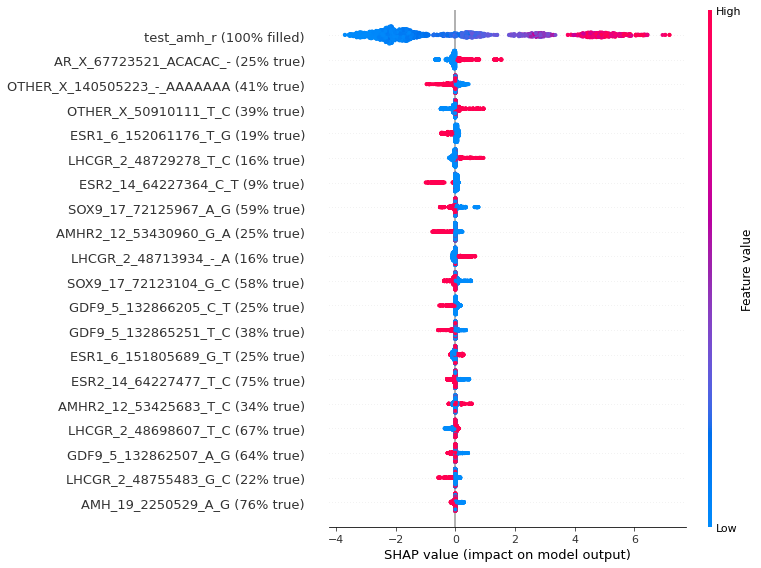

In [174]:
explain_model(
    X_RESULTS,
    data_serie_name='day_0_mii',
    folds=range(0, N_FOLDS),
    only_summary=True)